Analyze Features Driving High Production (Using Cluster Labels)


1. Load Cluster-Labeled Dataset

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Load dataset with production labels (from clustering)
df_clustered = pd.read_csv("all_features_present_labeled_clusters_KMeans_k_2_sel.csv")

df_clustered.replace({True: 1, False: 0}, inplace=True)

# Confirm structure
df_clustered.head()


c:\Users\utkar\.conda\envs\AI_Lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Prod_Label_KMeans_k=2_sel,Biological Weight (BW),C_2,ChlorophyllA663,Chlorophyllb649,G_2,G_3,G_4,G_5,G_6,...,Number of Seeds per Pod (NSP),Plant Height (PH),Protein Content (PCO),Protein Percentage (PPE),Relative Water Content in Leaves (RWCL),S_2,S_3,Seed Yield per Unit Area (SYUA),Sugars (Su),Weight of 300 Seeds (W3S)
0,0,111,0,1.4,3.1,0,0,0,1,0,...,1.86,50.5,0.82,33.2,0.732,0,0,5567.4,0.433,33.6
1,0,80,1,7.1,2.2,0,0,1,0,0,...,1.87,44.5,0.13,38.5,0.674,0,1,2245.5,0.334,34.4
2,0,83,1,1.8,1.3,0,0,0,0,1,...,2.04,52.2,0.15,33.6,0.677,0,0,4326.7,0.490,35.2
3,1,66,0,1.1,3.0,0,0,0,0,0,...,2.20,50.5,0.14,33.5,0.745,0,0,6214.5,0.163,52.3
4,0,73,0,7.5,2.1,0,0,0,0,1,...,1.88,49.2,0.60,39.6,0.725,1,0,3897.8,0.795,31.2


 2. Set Up Feature Matrix and Target

In [3]:
# Set target label (clustered production class)
target_col = "Prod_Label_KMeans_k=2_sel"  # 0 = Poor, 1 = Good

# Ensure it's integer
df_clustered[target_col] = df_clustered[target_col].astype(int)

# Remove ID columns if present
drop_cols = ["Parameters", "Random "] if "Parameters" in df_clustered.columns else []

# Set features: everything except the target & drop_cols
feature_cols = df_clustered.drop(columns=[target_col] + drop_cols, errors="ignore").columns.tolist()

X = df_clustered[feature_cols]
y = df_clustered[target_col]


3. Train a Classifier

In [4]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Score
print(f"✅ Accuracy on test set: {clf.score(X_test, y_test) * 100:.2f}%")

✅ Accuracy on test set: 92.59%


 4. SHAP Explainability

In [5]:
# parameters = ["G_2", "G_3", "G_4", "G_5", "G_6", "S_2", "S_3", "C_2"]
# X_parameters = df_clustered[parameters]

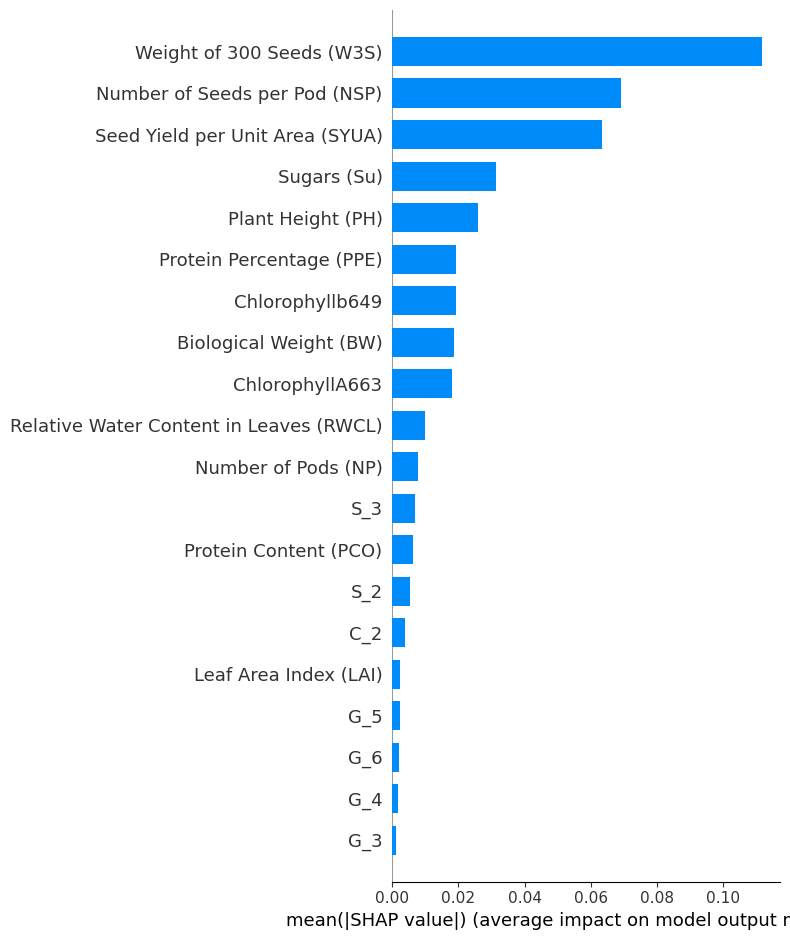

In [8]:
# SHAP Explainer
explainer = shap.Explainer(clf, X, model_output="probability")
shap_values = explainer(X, check_additivity=False)

# For class 1 = High Production
shap_values_class1 = shap_values[:, :, 1]

# Plot SHAP Summary
shap.summary_plot(shap_values_class1.values, X, feature_names=X.columns, plot_type="bar")

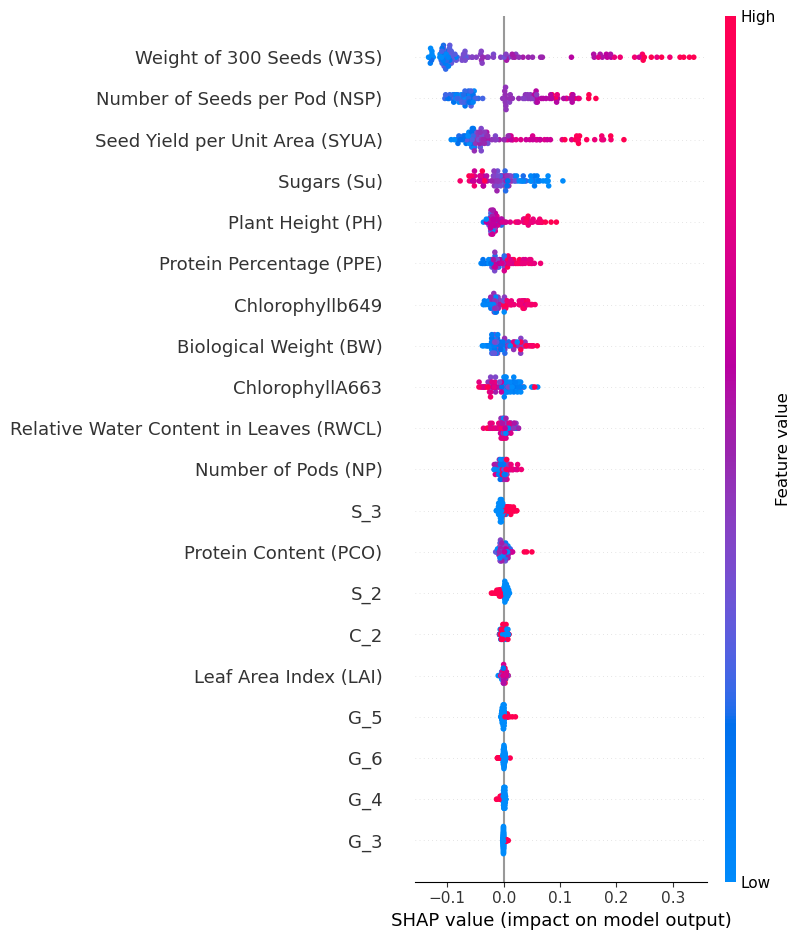

In [9]:
shap.summary_plot(shap_values_class1.values, X, feature_names=X.columns, plot_type="dot")

5. Visualize Top Features

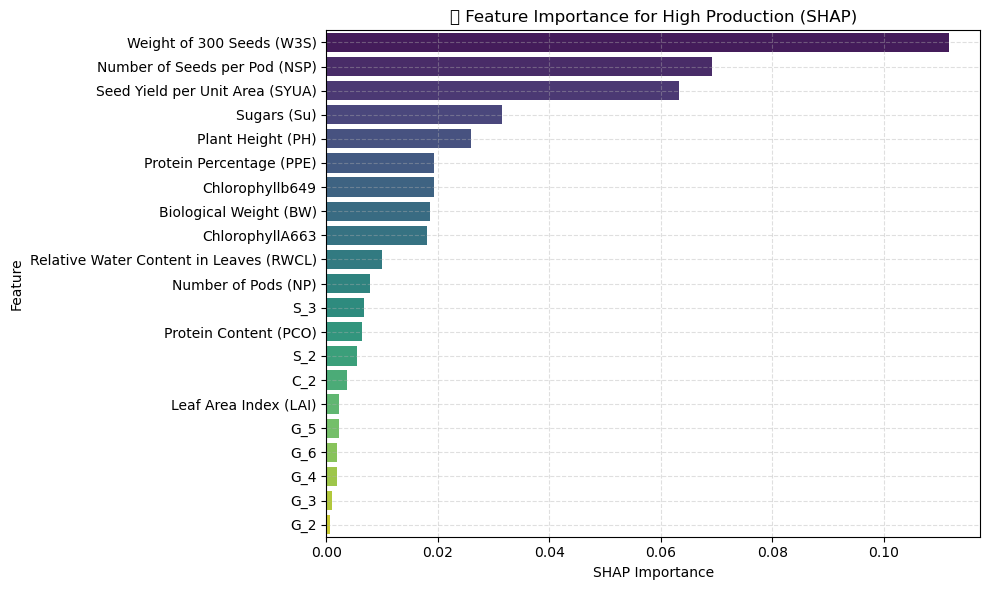

In [10]:
# Get SHAP feature importance
shap_mean = np.abs(shap_values_class1.values).mean(axis=0)
shap_df = pd.DataFrame({"Feature": X.columns, "SHAP Importance": shap_mean})
shap_df = shap_df.sort_values("SHAP Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_df, x="SHAP Importance", y="Feature", palette="viridis")
plt.title("🔍 Feature Importance for High Production (SHAP)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# shap_df.to_csv("shap_feature_importance_high_production.csv", index=False)
